In [ ]:
# Abigail Kelly
# Assignment 4
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from scipy.sparse.linalg import spsolve
from scipy.sparse import spdiags
import scipy as sp

In [ ]:
def analytical_solution(max_xy, dxy, flag = 0):
  M = int(max_xy / dxy) - 1 # y values are down the rows
  N = int(max_xy / dxy) - 1# x values are across the columns
  t = 1

  analytical = np.zeros((N,M))

  for i in range(M):
    y = i * dxy  # Adjusted y value
    for j in range(N):
        x = j * dxy  # Adjusted x value
        result = 0
        for n in range(1, 15):
            result += (1 - (-1)**n) * (2 / (n * np.pi)) * np.sin((n * np.pi * x) / 2) * np.exp(((-np.pi**2) / 4) * (n**2 + 1) * t)
        analytical[i, j] = np.sin((np.pi / 2) * y) * result

  if flag != 0:
    x = np.linspace(0, max_xy, N)
    y = np.linspace(0, max_xy, M)
    X, T = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, T, analytical, cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    plt.title(f'Analytical Solution at t = {t}, h = {dxy}')
    plt.show()

  return analytical

def backward_euler(max_xy, dxy, max_t, dt, flag=0):
  M = int(max_xy / dxy) - 1  # Number of grid points in y-direction
  N = int(max_xy / dxy) - 1 # Number of grid points in x-direction
  r = dt / dxy**2
  time_steps = int(max_t / dt) + 1 # Number of time stamps

  # [time, x, y]
  U = np.zeros((time_steps, M + 2, N + 2))

  # set the initial condition
  y = 0
  for i in range(N + 2):
    y = i * dxy
    for j in range(M + 2):
      U[0, i, j] = np.sin(np.pi * y / 2)

  # set the boundary conditions (when x, y = 0 = T)
  U[:, :, 0] = 0
  U[:, :, -1] = 0
  U[:, 0, :] =  0
  U[:, -1, :] = 0

  # Create matrix A
  A = np.zeros((M * N, M * N))
  np.fill_diagonal(A, -4)
  np.fill_diagonal(A[1:], 1)
  np.fill_diagonal(A[:, 1:], 1)
  np.fill_diagonal(A[M:], 1)
  np.fill_diagonal(A[:, M:], 1)

  # Add the scattered 0s on the diagonals right above and below the main diagonal
  for i in range(1, M):
    x_idx = i * N - 1
    y_idx = i * N
    A[x_idx, y_idx] = 0
    A[y_idx, x_idx] = 0

  # Calculate B = I - rA
  I = np.identity(M * N)
  B = I - r * A

  for i in range(time_steps - 1):
    U[i + 1][1:-1, 1:-1] = np.reshape(np.linalg.solve(B, (U[i][1:-1,1:-1]).flatten('F')), (M,N), order='F')

  if flag != 0:
    # Plot the 3D surface at t = 1
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.linspace(0, max_xy, int(max_xy / dxy)+1)
    y = np.linspace(0, max_xy, int(max_xy / dxy)+1)
    X, Y = np.meshgrid(x, y)
    ax.plot_surface(X, Y, U[-1], cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    plt.title(f'Backward Euler at t = 1, h = {dxy}, tau = {dt}')
    plt.show()

  return U[-1]

def crank_nicolson(max_xy, dxy, max_t, dt, flag = 0):
  M = int(max_xy / dxy) - 1  # Number of grid points in y-direction
  N = int(max_xy / dxy) - 1 # Number of grid points in x-direction
  r = dt / dxy**2
  time_steps = int(max_t / dt) + 1 # Number of time stamps

  # [time, x, y]
  U = np.zeros((time_steps, M + 2, N + 2))

  # set the initial condition
  y = 0
  for i in range(N + 2):
    y = i * dxy
    for j in range(M + 2):
      U[0, i, j] = np.sin(np.pi * y / 2)

  # set the boundary conditions (when x, y = 0 = T)
  U[:, :, 0] = 0
  U[:, :, -1] = 0
  U[:, 0, :] =  0
  U[:, -1, :] = 0

  # Create matrix A
  A = np.zeros((M * N, M * N))
  np.fill_diagonal(A, -4)
  np.fill_diagonal(A[1:], 1)
  np.fill_diagonal(A[:, 1:], 1)
  np.fill_diagonal(A[M:], 1)
  np.fill_diagonal(A[:, M:], 1)

  # Add the scattered 0s on the diagonals right above and below the main diagonal
  for i in range(1, M):
      x_idx = i * N - 1
      y_idx = i * N
      A[x_idx, y_idx] = 0
      A[y_idx, x_idx] = 0

  I = sp.sparse.identity(M*N, format = "csc")
  B = I - r/2 *A
  C = I + r/2 *A

  for i in range(time_steps - 1):
      U[i+1][1:-1,1:-1] = ((U[i][1:-1,1:-1]).flatten('F') * C).reshape((N, M), order='F')
      U[i + 1][1:-1,1:-1] = np.reshape(np.linalg.solve(B,(U[i+1][1:-1,1:-1]).flatten('F')), (M,N), order='F')

  if flag != 0:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.linspace(0, max_xy, int(max_xy / dxy)+1)
    y = np.linspace(0, max_xy, int(max_xy / dxy)+1)
    X, Y = np.meshgrid(x, y)
    ax.plot_surface(X, Y, U[-1], cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('Temperature')
    plt.title(f'Crank Nicolson at t = 1, h = {dxy}, tau = {dt}')
    plt.show()

  return U[-1]

def extrapolation(max_xy, dxy, max_t, dt, flag = 0):
  M = int(max_xy / dxy) - 1  # Number of grid points in y-direction
  N = int(max_xy / dxy) - 1 # Number of grid points in x-direction
  r = dt / dxy**2
  time_steps = int(max_t / dt) + 1 # Number of time stamps

  # [time, x, y]
  U = np.zeros((time_steps, M + 2, N + 2))

  # set the initial condition
  y = 0
  for i in range(N + 2):
    y = i * dxy
    for j in range(M + 2):
      U[0, i, j] = np.sin(np.pi * y / 2)

  # set the boundary conditions (when x, y = 0 = T)
  U[:, :, 0] = 0
  U[:, :, -1] = 0
  U[:, 0, :] =  0
  U[:, -1, :] = 0

  # Create matrix A
  A = np.zeros((M * N, M * N))
  np.fill_diagonal(A, -4)
  np.fill_diagonal(A[1:], 1)
  np.fill_diagonal(A[:, 1:], 1)
  np.fill_diagonal(A[M:], 1)
  np.fill_diagonal(A[:, M:], 1)

  # Add the scattered 0s on the diagonals right above and below the main diagonal
  for i in range(1, M):
      x_idx = i * N - 1
      y_idx = i * N
      A[x_idx, y_idx] = 0
      A[y_idx, x_idx] = 0

  I = np.identity(M*N)
  v1 = I - 2 * r * A
  v2 = I - r * A

  for i in range(0, time_steps - 1, 2):
    v1_1 = np.reshape(np.linalg.solve(v1, (U[i][1:-1,1:-1]).flatten('F')), (N,M), order = 'F')
    v2_2 = np.reshape(np.linalg.solve(v2, np.linalg.solve(v2, (U[i][1:-1,1:-1]).flatten('F'))), (N,M), order = 'F')
    U[i + 2][1:-1,1:-1] = 2*v2_2 - v1_1


  if flag != 0:
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = np.linspace(0, max_xy, int(max_xy / dxy) + 1)
    y = np.linspace(0, max_xy, int(max_xy / dxy) + 1)
    X, Y = np.meshgrid(x, y)
    ax.plot_surface(X, Y, U[-1], cmap='viridis')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('Temperature')
    plt.title(f'Extrapolation at t = 1, h = {dxy}, tau = {dt}')
    plt.show()

  return U[-1]

In [ ]:
# Question  1
tau = np.array([0.1, 0.01])
h = np.array([0.1, 0.05, 0.025])
#tau = np.array([0.1])
#h = np.array([0.1])
max_xy = 2
max_t = 1

euler_L2_norms = []
crank_L2_norms = []
extrapolation_L2_norms = []
euler_inf_norms = []
crank_inf_norms = []
extrapolation_inf_norms = []

for dt in tau:
  for dxy in h:
    analytical = analytical_solution(max_xy, dxy)
    euler = backward_euler(max_xy, dxy, max_t, dt)
    crank = crank_nicolson(max_xy, dxy, max_t, dt)
    extrap = extrapolation(max_xy, dxy, max_t, dt)

    euler_L2_norms.append(np.linalg.norm(analytical - euler))
    crank_L2_norms.append(np.linalg.norm(analytical - crank))
    extrapolation_L2_norms.append(np.linalg.norm(analytical - extrap))

    euler_inf_norms.append(np.linalg.norm(analytical - euler, ord=np.inf))
    crank_inf_norms.append(np.linalg.norm(analytical - crank, ord=np.inf))
    extrapolation_inf_norms.append(np.linalg.norm(analytical - extrap, ord=np.inf))

print(f'                               L 2 Errors')
print(f'                               tau = 0.1                           tau = 0.01')
print(f'Method                h = 0.1   h = 0.05   h = 0.025       h = 0.1   h = 0.05   h = 0.025')
print(f'-----------------------------------------------------------------------------------------')
print(f'Crank-Nicolson        {crank_L2_norms[0]:.2e}  {crank_L2_norms[1]:.2e}   {crank_L2_norms[2]:.2e}        {crank_L2_norms[3]:.2e}  {crank_L2_norms[4]:.2e}   {crank_L2_norms[5]:.2e}')
print(f'Backward-Difference   {euler_L2_norms[0]:.2e}  {euler_L2_norms[1]:.2e}   {euler_L2_norms[2]:.2e}        {euler_L2_norms[3]:.2e}  {euler_L2_norms[4]:.2e}   {euler_L2_norms[5]:.2e}')
print(f'Extrapolation         {extrapolation_L2_norms[0]:.2e}  {extrapolation_L2_norms[1]:.2e}   {extrapolation_L2_norms[2]:.2e}        {extrapolation_L2_norms[3]:.2e}  {extrapolation_L2_norms[4]:.2e}   {extrapolation_L2_norms[5]:.2e}')
print('\n')
print(f'                             L inf Errors')
print(f'                               tau = 0.1                           tau = 0.01')
print(f'Method                h = 0.1   h = 0.05   h = 0.025       h = 0.1   h = 0.05   h = 0.025')
print(f'-----------------------------------------------------------------------------------------')
print(f'Crank-Nicolson        {crank_inf_norms[0]:.2e}  {crank_inf_norms[1]:.2e}   {crank_inf_norms[2]:.2e}        {crank_inf_norms[3]:.2e}  {crank_inf_norms[4]:.2e}   {crank_inf_norms[5]:.2e}')
print(f'Backward-Difference   {euler_inf_norms[0]:.2e}  {euler_inf_norms[1]:.2e}   {euler_inf_norms[2]:.2e}        {euler_inf_norms[3]:.2e}  {euler_inf_norms[4]:.2e}   {euler_inf_norms[5]:.2e}')
print(f'Extrapolation         {extrapolation_inf_norms[0]:.2e}  {extrapolation_inf_norms[1]:.2e}   {extrapolation_inf_norms[2]:.2e}        {extrapolation_inf_norms[3]:.2e}  {extrapolation_inf_norms[4]:.2e}   {extrapolation_inf_norms[5]:.2e}')

                               L 2 Errors
                               tau = 0.1                           tau = 0.01
Method                h = 0.1   h = 0.05   h = 0.025       h = 0.1   h = 0.05   h = 0.025
-----------------------------------------------------------------------------------------
Crank-Nicolson        2.95e-01  1.83e+00   5.64e+00        6.51e-04  1.87e-04   9.43e-04
Backward-Difference   1.40e-01  2.79e-01   5.57e-01        1.22e-02  2.33e-02   4.60e-02
Extrapolation         2.92e-02  5.72e-02   1.14e-01        1.38e-03  1.65e-03   2.74e-03


                             L inf Errors
                               tau = 0.1                           tau = 0.01
Method                h = 0.1   h = 0.05   h = 0.025       h = 0.1   h = 0.05   h = 0.025
-----------------------------------------------------------------------------------------
Crank-Nicolson        2.13e-01  8.98e-01   2.53e+00        8.27e-04  2.38e-04   6.35e-04
Backward-Difference   1.78e-01  3.55e-01  

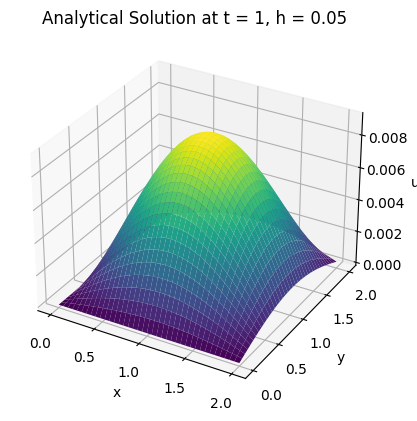

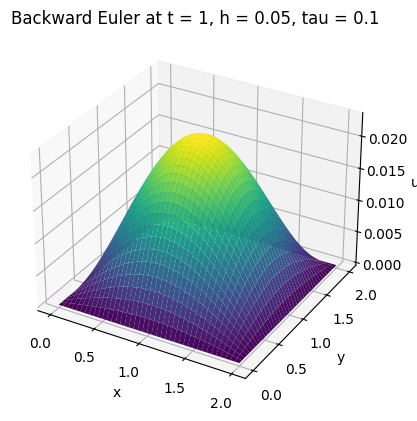

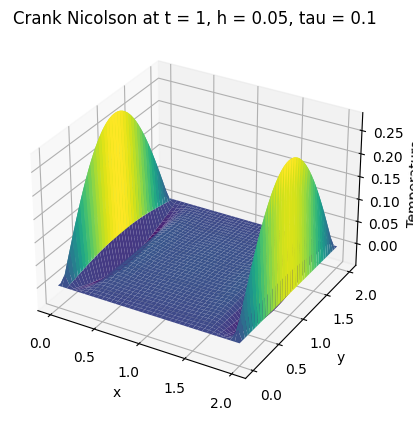

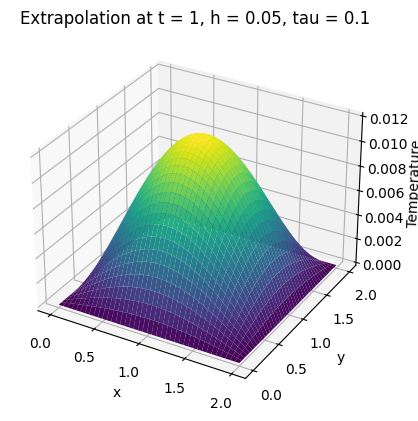

In [ ]:
# Question 2
max_xy = 2
dxy = 0.05
max_t = 1
dt = 0.1
analytical = analytical_solution(max_xy, dxy, 1)
euler = backward_euler(max_xy, dxy, max_t, dt, 1)
crank = crank_nicolson(max_xy, dxy, max_t, dt, 1)
extrap = extrapolation(max_xy, dxy, max_t, dt, 1)